In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Skeleton code for CW2 submission. 
We suggest you implement your code in the provided functions
Make sure to use our print_features() and print_predictions() functions
to print your results
"""

from __future__ import print_function

import argparse
import numpy as np
import matplotlib.pyplot as plt
from utilities import load_data, print_features, print_predictions
from scipy import stats

from sklearn.decomposition import PCA

# you may use these colours to produce the scatter plots
CLASS_1_C = r'#3366ff'
CLASS_2_C = r'#cc3300'
CLASS_3_C = r'#ffc34d'

MODES = ['feature_sel', 'knn', 'alt', 'knn_3d', 'knn_pca']    
# My code
# Blue, Red, Yellow
class_colours = np.array([CLASS_1_C, CLASS_2_C, CLASS_3_C])
train_set, train_labels, test_set, test_labels = load_data()

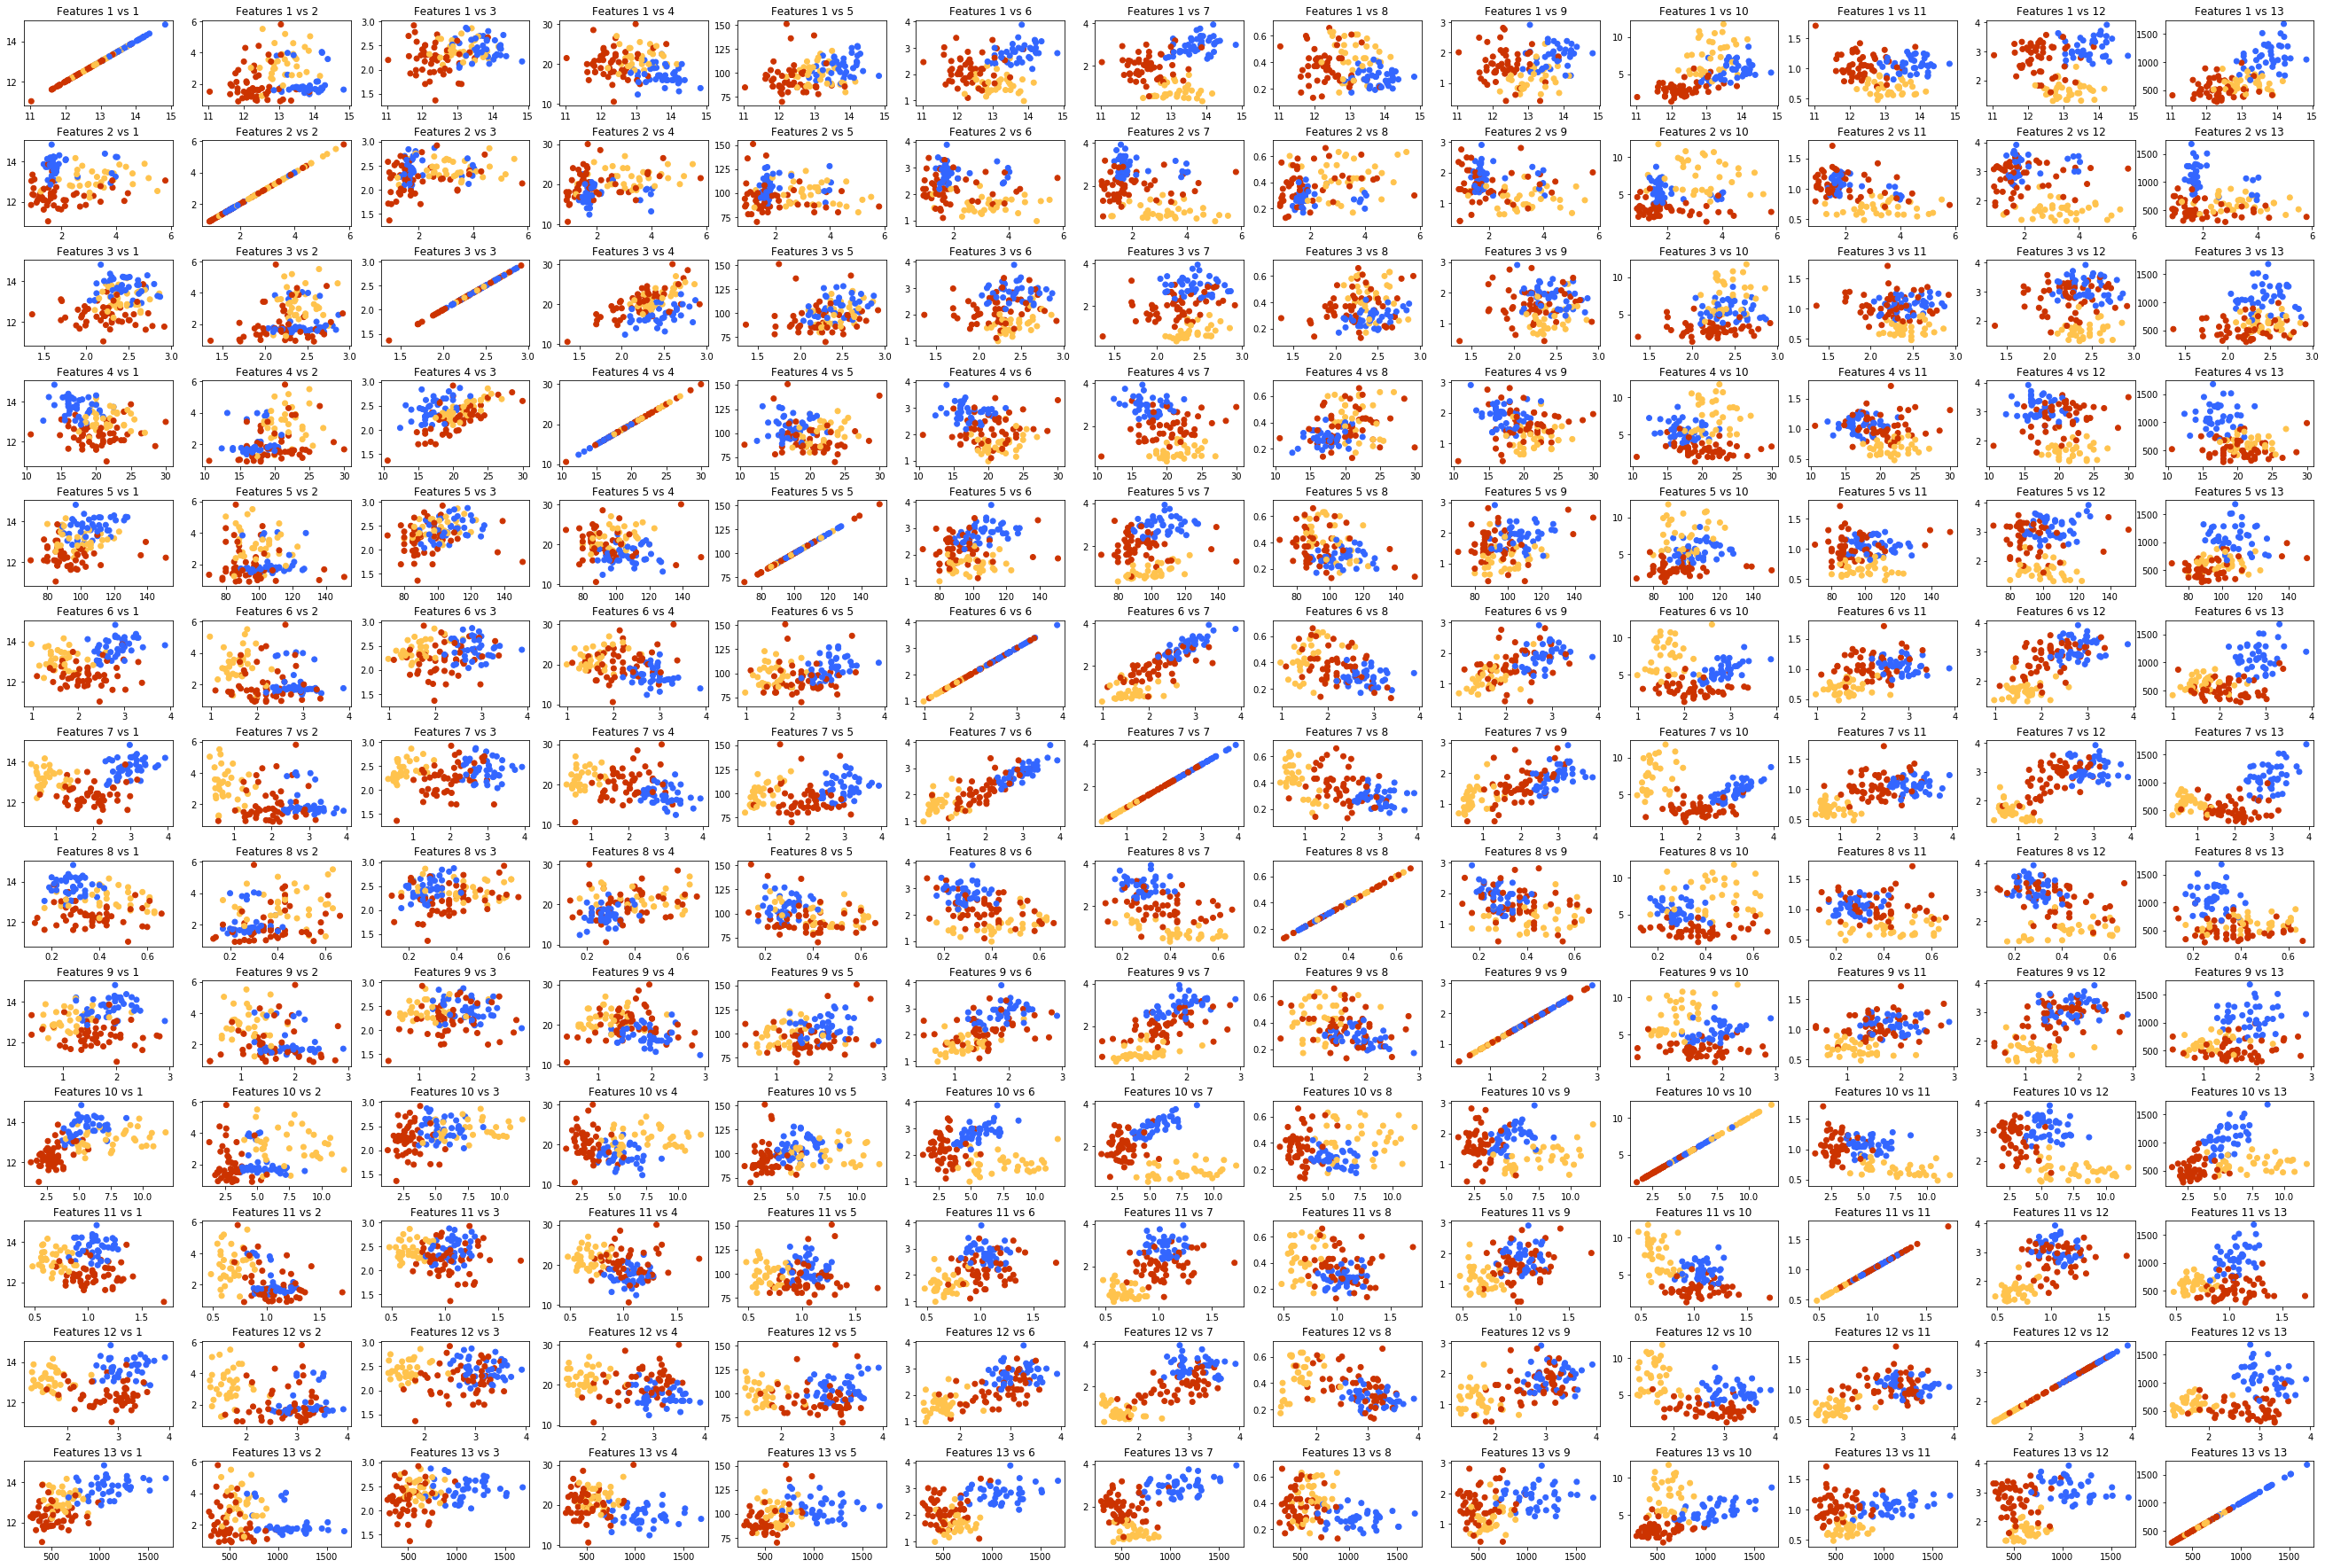

In [2]:
def myFunction_graph_combinations(train_set, train_labels):
    n_features = train_set.shape[1]
    fig, ax = plt.subplots(n_features, n_features)
    plt.subplots_adjust(left=0.01, right=5.99, top=5.99, bottom=0.01, wspace=0.2, hspace=0.4)
    for i in range(n_features):
        for j in range(n_features):
            ax[i][j].scatter(train_set[:, i], train_set[:, j], c=class_colours[train_labels[:]-1])
            ax[i][j].set_title('Features {} vs {}'.format(i+1, j+1))
myFunction_graph_combinations(train_set, train_labels)

In [3]:
def overlapping_numbers(feature, labels):
    olp_ns = np.zeros(3, dtype=int)
    for i in range(3):
        index = np.concatenate(np.argwhere(labels == i+1), axis=0)
        group_max = max(np.take(feature, index))
        group_min = min(np.take(feature, index))
        for j in range(feature.shape[0]):
            if feature[j] > group_min and feature[j] < group_max and labels[j] != i+1:
                olp_ns[i] += 1
    return olp_ns

def feature_selection(train_set, train_labels, n = 2, **kwargs):
    # write your code here and make sure you return the features at the end of 
    # the function
    features = []
    measurements = []
    for i in range(train_set.shape[1]):
        olp = overlapping_numbers(train_set[:,i], train_labels)
        measurements.append(sum(olp))
    print(measurements)
    for i in range(n):
        #argmin only takes the first of min
        features.append(np.argmin(measurements))
        measurements[np.argmin(measurements)] = float('inf')
    return features

feature_selection(train_set, train_labels)

[148, 211, 214, 187, 198, 143, 78, 204, 203, 114, 105, 104, 100]


[6, 12]

In [4]:
# 1-B 2-R 3-Y
def overlapping_numbers_pro(feature, labels):
    olp_ns = np.zeros(6, dtype=int)
    for i in range(3):
        index = np.concatenate(np.argwhere(labels == i+1), axis=0)
        group_max = max(np.take(feature, index))
        group_min = min(np.take(feature, index))
        for j in range(feature.shape[0]):
            if feature[j] > group_min and feature[j] < group_max and labels[j] == (i+1)%3+1:
                olp_ns[2*i] += 1
            if feature[j] > group_min and feature[j] < group_max and labels[j] == (i+2)%3+1:
                olp_ns[2*i+1] += 1
    return olp_ns

def feature_selection_plus(train_set, train_labels, f=2, **kwargs):
    # write your code here and make sure you return the features at the end of 
    # the function
    features = []
    measurements = []
    for i in range(train_set.shape[1]):
        olp = overlapping_numbers_pro(train_set[:,i], train_labels)
        measurements.append(olp)
    min_dotp = float('inf')
    for i in range(train_set.shape[1]-1):
        for j in range(i+1, train_set.shape[1]):
            if min_dotp > np.dot(measurements[i], measurements[j]): 
                min_dotp = np.dot(measurements[i], measurements[j])
                features = [i, j] 
    return features

feature_selection_plus(train_set, train_labels)

[6, 9]

In [5]:
def combinations(index, d, list_f):
    global temp_comb
    global min_comb
    global min_dotp
    if d == 1:
        for i in range(index, len(list_f)):
            temp_comb.append(i)
            dotp = 0
            for j in range(list_f[0].shape[0]):
                product = 1
                for k in temp_comb:
                    product *= list_f[k][j]
                dotp += product
            if dotp < min_dotp:
                min_dotp = dotp
                for m in range(len(temp_comb)):
                    min_comb[m] = temp_comb[m]
            del temp_comb[-1]
    else: 
        if d > 1:
            for i in range(index, len(list_f)-d+1):
                temp_comb.append(i)
                combinations(i+1, d-1, list_f)
                del temp_comb[-1]

def feature_selection_pro(train_set, train_labels, f=2, **kwargs):
    # write your code here and make sure you return the features at the end of 
    # the function
    measurements = []
    for i in range(train_set.shape[1]):
        olp = overlapping_numbers_pro(train_set[:,i], train_labels)
        measurements.append(olp)
    global min_dotp 
    min_dotp = float('inf')
    global min_comb
    min_comb = []
    for i in range(f):
        min_comb.append(i)
    global temp_comb
    temp_comb = []
    combinations(0, f, measurements)
    result = []
    for i in range(len(min_comb)):
        result.append(min_comb[i])
    del min_comb[-f:]
    return result

feature_selection_pro(train_set, train_labels, f=3)

[9, 10, 12]

In [6]:
def knn_core(train_set_f, train_labels, test_set_f, k):
    predict_labels = np.zeros(test_set_f.shape[0], dtype='int')
    
    for t in range(test_set_f.shape[0]):
        distances = np.zeros(train_set_f.shape[0])
        for i in range(train_set_f.shape[0]):
            for j in range(train_set_f.shape[1]):
                distances[i] += (test_set_f[t][j] - train_set_f[i][j]) ** 2
            distances[i] = distances[i] ** 0.5
        class_counter = np.zeros(3)
        for i in range(k):
            class_counter[train_labels[np.argmin(distances)] - 1] += 1
            distances[np.argmin(distances)] = float('inf')
        predict_labels[t] = np.argmax(class_counter) + 1
    return predict_labels


def knn(train_set, train_labels, test_set, k, **kwargs):
    # write your code here and make sure you return the predictions at the end of 
    # the function
    train_set_f = train_set[:, feature_selection_pro(train_set, train_labels)]
    test_set_f = test_set[:, feature_selection_pro(train_set, train_labels)]
    return knn_core(train_set_f, train_labels, test_set_f, k)
    
knn(train_set, train_labels, test_set, 7)-test_labels

array([-1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  1,  0,  0, -1,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0])

In [7]:
def accuracy(pred, label):
    counter = 0
    for i in range(pred.shape[0]):
        if pred[i] == label[i]:
            counter += 1
    return counter/len(pred)

for i in range(7):
    if i != 5:
        print(i+1, accuracy(knn(train_set, train_labels, test_set, i+1), test_labels))

1 0.9056603773584906
2 0.8679245283018868
3 0.8490566037735849
4 0.8679245283018868
5 0.7924528301886793
7 0.8301886792452831


In [8]:
def alternative_classifier(train_set, train_labels, test_set, **kwargs):
    # write your code here and make sure you return the predictions at the end of 
    # the function
    features = feature_selection_pro(train_set, train_labels)
    train_set_2d = train_set[:, features]
    test_set_2d = test_set[:, features]

    predictions = np.zeros(test_set.shape[0], dtype=int)

    indices_of_label1 = np.argwhere(train_labels == 1).flatten('F')
    indices_of_label2 = np.argwhere(train_labels == 2).flatten('F')
    indices_of_label3 = np.argwhere(train_labels == 3).flatten('F')

    train_set_2d_label1 = train_set_2d[indices_of_label1, :]
    train_set_2d_label2 = train_set_2d[indices_of_label2, :]
    train_set_2d_label3 = train_set_2d[indices_of_label3, :]
    
    cm1 = np.cov(train_set_2d_label1.T)
    mu1 = np.mean(train_set_2d_label1, axis = 0)
    cm2 = np.cov(train_set_2d_label2.T)
    mu2 = np.mean(train_set_2d_label2, axis = 0)
    cm3 = np.cov(train_set_2d_label3.T)
    mu3 = np.mean(train_set_2d_label3, axis = 0)
    
    for i in range(test_set.shape[0]):
        p1 = stats.multivariate_normal.pdf(test_set_2d[i,:], mean = mu1, cov = cm1)
        p2 = stats.multivariate_normal.pdf(test_set_2d[i,:], mean = mu2, cov = cm2)
        p3 = stats.multivariate_normal.pdf(test_set_2d[i,:], mean = mu3, cov = cm3)
        predictions[i] = np.argmax([p1, p2, p3])+1

    return predictions

accuracy(alternative_classifier(train_set, train_labels, test_set), test_labels)

0.8867924528301887

In [9]:
def knn_three_features(train_set, train_labels, test_set, k, **kwargs):
    # write your code here and make sure you return the predictions at the end of 
    # the function
    train_set_f = train_set[:, feature_selection_pro(train_set, train_labels, 3)]
    test_set_f = test_set[:, feature_selection_pro(train_set, train_labels, 3)]
    return knn_core(train_set_f, train_labels, test_set_f, k)

print(knn_three_features(train_set, train_labels, test_set, 7)-test_labels)
for i in range(7):
    if i != 5:
        print(i+1, accuracy(knn_three_features(train_set, train_labels, test_set, i+1), test_labels))

[ 0  0  2  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0 -1  0  0  1  0  0  0  1 -1  0  2 -1  0 -1  0  0  0 -2  0  1  0  0
  0  0  1  0  0]
1 0.7547169811320755
2 0.6981132075471698
3 0.7735849056603774
4 0.7547169811320755
5 0.6981132075471698
7 0.7358490566037735


[2 1 1 1 3 3 2 3 1 2 1 1 2 2 2 2 1 2 1 1 1 1 3 1 3 3 1 1 2 2 2 2 1 3 3 2 1
 2 3 2 3 2 2 1 1 3 2 3 1 3 3 1 1]
1 0.7358490566037735
2 0.7358490566037735
3 0.7169811320754716
4 0.6792452830188679
5 0.7358490566037735
7 0.7169811320754716


C:\Users\WHY\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


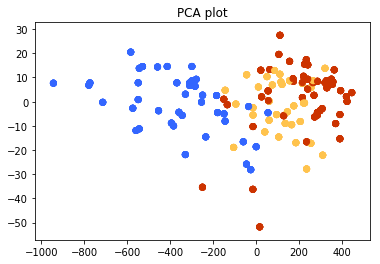

In [10]:
def pca_core(data_set, n_components):
    norm_data_set = data_set - np.mean(data_set, axis = 0)
    cov_matrix = np.cov(norm_data_set, rowvar = False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    order = np.flip(np.argsort(eigenvalues), axis = 0)[0:n_components]
    W = eigenvectors[:,order]
    myPCA = np.dot(norm_data_set, W)
    return myPCA

def knn_pca(train_set, train_labels, test_set, k, n_components=2, **kwargs):
    # write your code here and make sure you return the predictions at the end of 
    # the function
    pca_train_set = pca_core(train_set, n_components)
    pca_test_set = pca_core(test_set, n_components)
    pred_pca = knn_core(pca_train_set, train_labels, pca_test_set, k)
    pca_plot = plt.subplot()
    pca_plot.scatter(pca_train_set[:, 0], pca_train_set[:, 1], c=class_colours[train_labels[:]-1])
    pca_plot.set_title('PCA plot')
    return pred_pca

print(knn_pca(train_set, train_labels, test_set, 7))

for i in range(7):
    if i != 5:
        print(i+1, accuracy(knn_pca(train_set, train_labels, test_set, i+1), test_labels))

1 0.7169811320754716
2 0.6415094339622641
3 0.660377358490566
4 0.7169811320754716
5 0.7547169811320755
7 0.7547169811320755


C:\Users\WHY\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


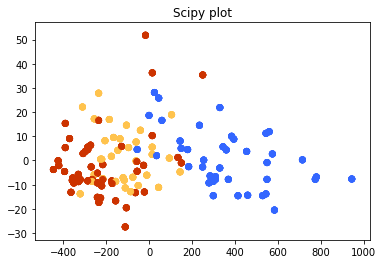

In [11]:
def knn_scipy_pca(train_set, train_labels, test_set, k, n_components=2, **kwargs):
    pca = PCA(n_components=2)
    pca.fit(train_set)
    scipy = pca.transform(train_set)
    scipy_test = pca.transform(test_set)
    scipy_plot = plt.subplot()
    scipy_plot.scatter(scipy[:, 0], scipy[:, 1], c=class_colours[train_labels[:]-1])
    scipy_plot.set_title('Scipy plot')
    return knn_core(scipy, train_labels, scipy_test, k)

for i in range(7):
    if i != 5:
        print(i+1, accuracy(knn_scipy_pca(train_set, train_labels, test_set, i+1), test_labels))

In [31]:
def k_means (data_set, k):
    number_of_sample = data_set.shape[0]
    number_of_dimension = data_set.shape[1]
    
    centroids = np.zeros((k, number_of_dimension))
    for dimension in range(number_of_dimension):
        range_in_dimension = float(max(data_set[:, dimension]) - min(data_set[:, dimension]))
        centroids[:, dimension] = min(data_set[:, dimension]) + range_in_dimension * np.random.rand(k)
        
    position_changed = True
    labels = np.zeros(number_of_sample, dtype='int')
    i = 0
    while position_changed and i < 10:
        position_changed = False
        for sample in range(number_of_sample):
            min_distance = np.inf
            centroid_index = -1
            for centroid in range(k):
                distance = np.sqrt(sum((data_set[sample, :] - centroids[centroid, :]) ** 2))
                if distance < min_distance:
                    min_distance = distance
                    centroid_index = centroid
            labels[sample] = centroid_index
        for centroid in range(k):
            if len(data_set) == 0:
                if len(centroids[centroid]) != 0:
                    changed = True
            else:
                cluster_mean = np.mean(data_set[labels[:] == centroid], axis=0)
                changed = (cluster_mean != centroids[centroid]).all()
            if changed:
                position_changed = True
            centroids[centroid] = cluster_mean
    return centroids, labels

def alternative_classifier_k_means(train_set, train_labels, test_set, **kwargs):
    # write your code here and make sure you return the predictions at the end of 
    # the function
    test_set_2f = test_set[:, feature_selection_pro(train_set, train_labels)]
    centroids, labels = k_means(test_set_2f, 3)
    return labels+1
print(alternative_classifier_k_means(train_set, train_labels, test_set)-test_labels)

[ 1  2  2  0  1 -2 -2 -2  0  1  2  0  1  1  1  1  2  1  0 -2  2  2  0  2
  1 -1  1  0 -2  1  1  1  2  1 -2  1  2  0  0  0  1  1  0 -2  2  1  1  1
  2 -2  1  2  2]


In [32]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('mode', nargs=1, type=str, help='Running mode. Must be one of the following modes: {}'.format(MODES))
    parser.add_argument('--k', nargs='?', type=int, default=1, help='Number of neighbours for knn')
    parser.add_argument('--train_set_path', nargs='?', type=str, default='data/wine_train.csv', help='Path to the training set csv')
    parser.add_argument('--train_labels_path', nargs='?', type=str, default='data/wine_train_labels.csv', help='Path to training labels')
    parser.add_argument('--test_set_path', nargs='?', type=str, default='data/wine_test.csv', help='Path to the test set csv')
    parser.add_argument('--test_labels_path', nargs='?', type=str, default='data/wine_test_labels.csv', help='Path to the test labels csv')
    
    args = parser.parse_args()
    mode = args.mode[0]
    
    return args, mode


if __name__ == '__main__':
    args, mode = parse_args() # get argument from the command line
    
    # load the data
    train_set, train_labels, test_set, test_labels = load_data(train_set_path=args.train_set_path, 
                                                                       train_labels_path=args.train_labels_path,
                                                                       test_set_path=args.test_set_path,
                                                                       test_labels_path=args.test_labels_path)
    if mode == 'feature_sel':
        selected_features = feature_selection(train_set, train_labels)
        print_features(selected_features)
    elif mode == 'knn':
        predictions = knn(train_set, train_labels, test_set, args.k)
        print_predictions(predictions)
    elif mode == 'alt':
        predictions = alternative_classifier(train_set, train_labels, test_set)
        print_predictions(predictions)
    elif mode == 'knn_3d':
        predictions = knn_three_features(train_set, train_labels, test_set, args.k)
        print_predictions(predictions)
    elif mode == 'knn_pca':
        prediction = knn_pca(train_set, train_labels, test_set, args.k)
        print_predictions(prediction)
    else:
        raise Exception('Unrecognised mode: {}. Possible modes are: {}'.format(mode, MODES))

usage: ipykernel_launcher.py [-h] [--k [K]]
                             [--train_set_path [TRAIN_SET_PATH]]
                             [--train_labels_path [TRAIN_LABELS_PATH]]
                             [--test_set_path [TEST_SET_PATH]]
                             [--test_labels_path [TEST_LABELS_PATH]]
                             mode
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

C:\Users\WHY\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
